In [1]:
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pyd
import pandas as pd

In [2]:
client = MongoClient('localhost', 27017)
db = client['rsna-xray']
col = db['patient']

In [3]:
randomsample = col.aggregate([{'$sample':{'size':25}}])
randomsample = [patient for patient in randomsample]

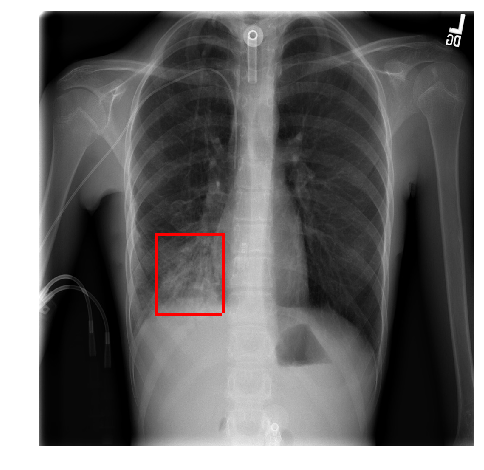

In [52]:
def draw(data, show = True):
    #Function to draw a bounding box of a random color if 
    #the pa
    # --- Open DICOM file
    d = pyd.read_file(data['path'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    if data["target"] == 1:
        for box in data['targets']:
            rgb = np.array([255,0,0]).astype('int')
            im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    if show == True:
        plt.imshow(im, cmap=plt.cm.bone)
        plt.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    x1, y1, width, height = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:(y1 + stroke), x1:x2] = rgb
    im[y2:(y2 + stroke), x1:x2] = rgb
    im[y1:y2, x1:(x1 + stroke)] = rgb
    im[y1:y2, x2:(x2 + stroke)] = rgb

    return im

draw(col.find_one({"num_instances":1}), show= True)

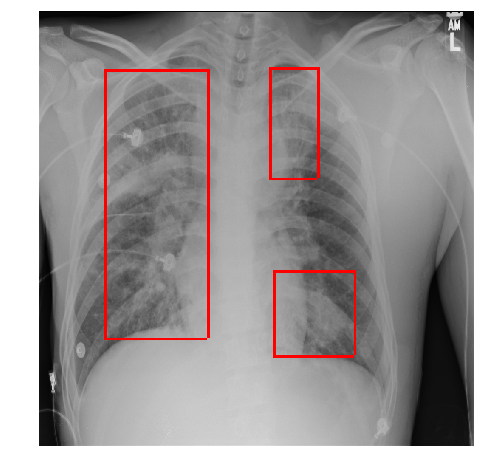

In [53]:
onePatient = col.find_one({"num_instances":3})
draw(onePatient)

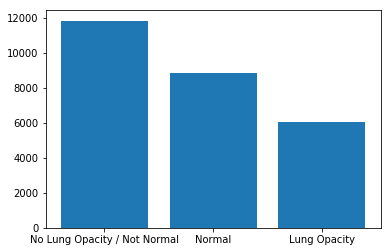

In [6]:
#Looking at the number of instances for each of the classes
numClasses = col.aggregate(
   [
      {
        "$group" : {
           "_id" : "$class",
           "count": { "$sum": 1 }
        }
      }
   ]
)
#Making a list of the classes
classes = [i for i in numClasses]
#putting the aggregation in a data frame
classCount = pd.DataFrame(classes)
plt.bar(x = "_id", height = "count", data = classCount)
plt.show()

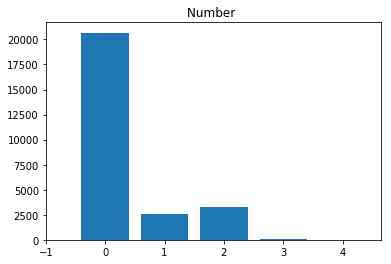

In [7]:
#Looking at the number of instances for each of the classes
instances = col.aggregate(
   [
      {
        "$group" : {
           "_id" : "$num_instances",
           "count": { "$sum": 1 }
        }
      }
   ]
)
#putting aggregation into a list
instances = [i for i in instances]
#putting aggregation into a data frame
instances = pd.DataFrame(instances)
instances = instances.rename({"_id":"Number of Detections"}, axis=1)
plt.bar(x = "Number of Detections", height = "count", data = instances)
plt.xticks(np.arange(-1, 5, step=1))
plt.title("Number ")
plt.show()

In [8]:
instances.sort_values(by = "Number of Detections")

,Number of Detections,count
3,0,20672
4,1,2614
1,2,3266
0,3,119
2,4,13


In [9]:
#Getting all patients with lung opacities
target_sizes = col.find({"target": 1})
#Getting all the widths
widths = [target[2] for patient in target_sizes for target in patient["targets"]]

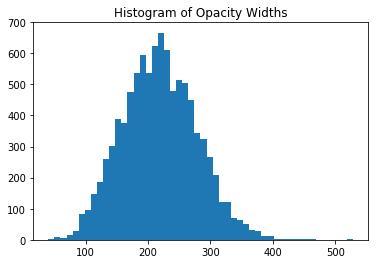

In [10]:
plt.hist(widths, bins=50)
plt.title("Histogram of Opacity Widths")
plt.show()

In [11]:
#Getting all patients with lung opacities
target_sizes = col.find({"target": 1})
#Getting all the widths
heights = [target[3] for patient in target_sizes for target in patient["targets"]]

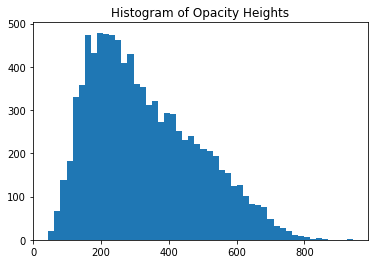

In [12]:
plt.hist(heights, bins=50)
plt.title("Histogram of Opacity Heights")
plt.show()

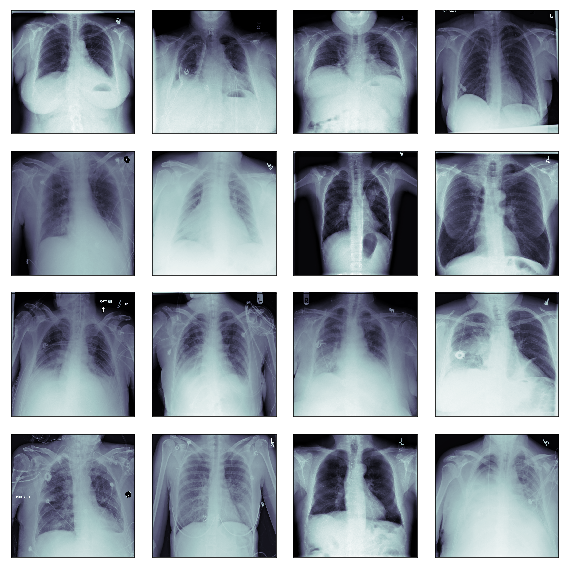

In [23]:
not_normal = col.find({"class":"No Lung Opacity / Not Normal"}).limit(16)
# visualize No lung opacity / Not Normal
plt.rcParams["figure.figsize"] = (8, 8)
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True,)
ax = ax.flatten()
for i, patient in enumerate(list(not_normal)):
    file = pyd.read_file(patient['path'])
    img = file.pixel_array
    ax[i].imshow(img, cmap=plt.cm.bone, interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

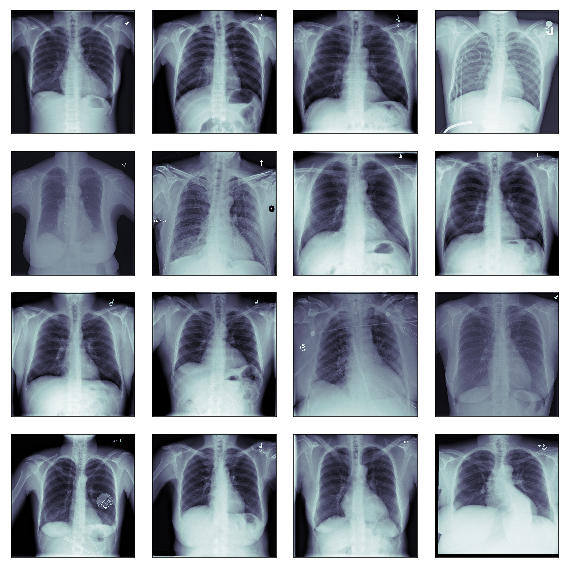

In [24]:
normal = col.find({"class":"Normal"}).limit(16)
# visualize Normal
plt.rcParams["figure.figsize"] = (8, 8)
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True,)
ax = ax.flatten()
for i, patient in enumerate(list(normal)):
    file = pyd.read_file(patient['path'])
    img = file.pixel_array
    ax[i].imshow(img, cmap=plt.cm.bone, interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

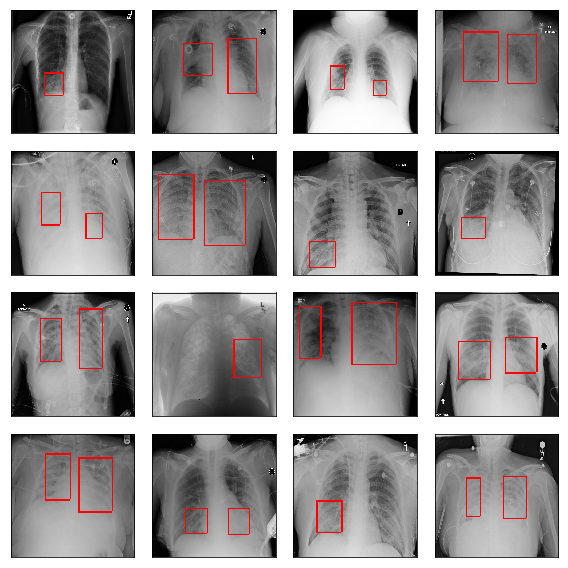

In [62]:
lung_opacity = col.find({"class":"Lung Opacity"}).limit(16)
lung_opacity = list(lung_opacity)
# visualize wrong predictions
plt.rcParams["figure.figsize"] = (8, 8)
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True,)
ax = ax.flatten()
for i, patient in enumerate(list(lung_opacity)):
    file = pyd.read_file(patient['path'])
    img = file.pixel_array
    img = np.stack([img] * 3, axis=2)
    for box in patient["targets"]:        
        rgb = np.array([255,0,0]).astype('int')
        img = overlay_box(im = img, box=box, rgb=rgb, stroke=10)
    ax[i].imshow(img, cmap=plt.cm.bone, interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()
#Different color due to stacking arrays

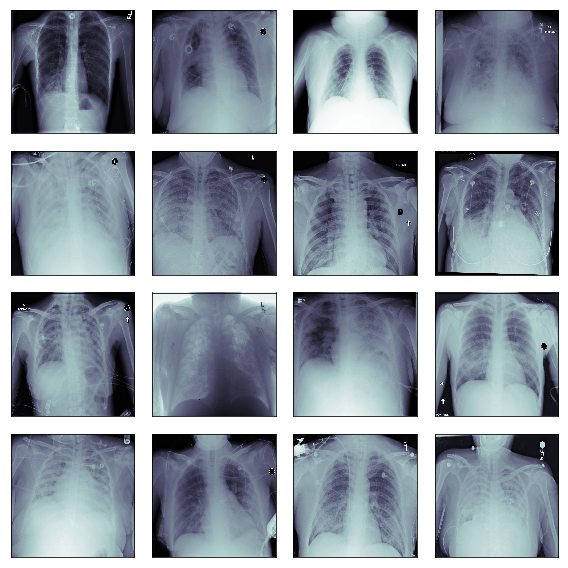

In [63]:
plt.rcParams["figure.figsize"] = (8, 8)
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True,)
ax = ax.flatten()
for i, patient in enumerate(lung_opacity):
    file = pyd.read_file(patient['path'])
    img = file.pixel_array
    ax[i].imshow(img, cmap=plt.cm.bone, interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()